In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import json
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [34]:
from agnfinder.prospector import load_photometry
from agnfinder.tf_sampling import deep_emulator

In [35]:
os.chdir('/home/mike/repos/agnfinder')

### Convert everything to parquet

In [36]:
data_dir = '/media/mike/beta/agnfinder/uK_IR/selected'
assert os.path.isdir(data_dir)
fits_locs = glob.glob(data_dir + '/*.fits')
assert fits_locs

In [37]:
for fits_loc in fits_locs:
    fits = Table.read(fits_loc)
    df = fits.to_pandas()
    parquet_loc = fits_loc.rstrip('fits') + 'parquet'
    df.to_parquet(parquet_loc)

### Check they load and normalise/denormalise correctly

In [38]:
parquet_locs = glob.glob(data_dir + '/*.parquet')
assert parquet_locs

In [39]:
def load_real_galaxy(parquet_loc):
    # not designed to scale easily, loads df every time. Can change to hdf5 later
    df = pd.read_parquet(parquet_loc)
    galaxy = df.iloc[0]
    _, maggies, maggies_unc = load_photometry.load_maggies_from_galaxy(galaxy, reliable=True)
    return maggies, maggies_unc

In [40]:
maggies, maggies_unc = load_real_galaxy(parquet_locs[0])

In [41]:
maggies

array([8.97925081e-09, 5.50088098e-08, 1.36326123e-07, 2.03466345e-07,
       2.86353580e-07, 4.03908316e-07, 3.27287289e-07, 3.92900064e-07,
       2.73501478e-07, 2.32374996e-07, 1.96871625e-07, 1.25575484e-07])

In [42]:
deep_emulator.denormalise_photometry(deep_emulator.normalise_photometry(maggies))

array([8.97925081e-09, 5.50088098e-08, 1.36326123e-07, 2.03466345e-07,
       2.86353580e-07, 4.03908316e-07, 3.27287289e-07, 3.92900064e-07,
       2.73501478e-07, 2.32374996e-07, 1.96871625e-07, 1.25575484e-07])

### Save as one parquet with a feature column indicating galaxy type

In [43]:
dfs = []
for loc in parquet_locs:
    dfs.append(pd.read_parquet(loc))
len(dfs)

6

In [44]:
df = pd.concat(dfs, axis=0).reset_index(drop=True)
len(df)

/media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


69

In [45]:
df.sample(5)

,CASE_III_a0,CASE_III_a0_001,CASE_III_a0_01,CASE_III_a0_05,CASE_III_b0,CASE_III_b0_001,CASE_III_b0_01,CASE_III_b0_05,CASE_III_c0,CASE_III_c0_001,...,zphot_II_a0_01,zphot_II_a0_05,zphot_II_b0,zphot_II_b0_001,zphot_II_b0_01,zphot_II_b0_05,zphot_I_a0,zphot_I_a0_001,zphot_I_a0_01,zphot_I_a0_05
3,2,2,2,1,1,1,1,1,2,2,...,0.0361,0.0245,0.0361,0.0361,0.0361,0.0361,0.0844,0.0844,0.0844,0.0844
38,2,2,2,1,1,1,1,1,2,2,...,0.0361,0.0245,0.0361,0.0361,0.0361,0.0361,0.0844,0.0844,0.0844,0.0844
25,1,1,1,1,2,2,2,2,3,3,...,0.0648,0.0648,0.0648,0.0648,0.0648,0.0648,0.0826,0.0826,0.0826,0.0648
19,5,5,5,5,5,5,5,5,5,5,...,2.1334,2.1334,2.1334,2.1334,2.1334,2.1334,2.1334,2.1334,2.1334,2.1334
2,2,2,2,1,1,1,1,1,2,2,...,0.1067,0.0904,0.1067,0.1067,0.1067,0.1067,0.0950,0.0950,0.0904,0.0904


In [46]:
# df.columns.values

### Having done that, turns out we actually want a bigger selection - so let's just use the main catalog...

In [47]:
catalog_loc = '/media/mike/beta/agnfinder/cpz_paper_sample_week3.parquet'
df = pd.read_parquet(catalog_loc)

In [48]:
hclass_schema = {
    1: 'galaxy',
    2: 'agn',
    3: 'qso',
    -1: 'unknown'
}
df['hclass_name'] = df['hclass'].apply(lambda x: hclass_schema[x])
df['hclass_name'].value_counts()

unknown    25343
galaxy     11369
qso         4192
agn          495
Name: hclass_name, dtype: int64

In [49]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']


In [50]:
for c in rf_classes:
    print('{}: {:.2f}'.format(c, df[f'Pr[{c}]_case_III'].sum()))

passive: 14852.45
starforming: 12800.21
starburst: 6735.99
agn: 4113.60
qso: 2896.75
outlier: 906.92


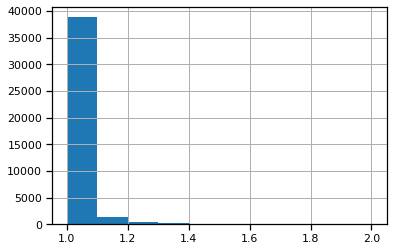

In [51]:
# check p's sum to 1
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
df[rf_cols].sum(axis=1).hist()
# close enough!

In [52]:
rf_classes

['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']

In [53]:
rf_cols

['Pr[passive]_case_III',
 'Pr[starforming]_case_III',
 'Pr[starburst]_case_III',
 'Pr[agn]_case_III',
 'Pr[qso]_case_III',
 'Pr[outlier]_case_III']

In [54]:
df = df.sample(int(len(df) / 3))  # for memory

In [55]:
df['most_likely_rf_class'] = df[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)

In [56]:
def get_p(x):
    c = x['most_likely_rf_class']
    return x[f'Pr[{c}]_case_III']

In [57]:
df['p_of_most_likely_rf_class'] = df.apply(get_p, axis=1)

In [61]:
df['most_likely_rf_class'].value_counts()

passive        5230
starforming    4986
starburst      1503
qso            1106
agn             918
outlier          56
Name: most_likely_rf_class, dtype: int64

In [59]:
def does_galaxy_load(galaxy):
    try:
        _ = load_photometry.load_maggies_from_galaxy(galaxy, reliable=True)
        return True
    except ValueError:
        return False

In [78]:
rf_cols_no_outlier = rf_cols[:-1]

In [84]:
n_per_class = 150
candidate_dfs = []
for col in rf_cols_no_outlier:
    cdf = df.sort_values(col, ascending=False)[:n_per_class]
    cdf['has_valid_filters'] = cdf.apply(does_galaxy_load, axis=1)
    cdf = cdf.query('has_valid_filters==True').reset_index()
    candidate_dfs.append(cdf)


In [85]:
selected_df = pd.concat(candidate_dfs, axis=0)
selected_df.head()

,index,id,alpha,delta,redshift,hclass,hquality,survey_quality,survey_comment,sp_survey,...,class_opt_a_2_case_III,class_opt_a_3_case_III,class_opt_b_0_case_III,class_opt_b_1_case_III,class_opt_b_2_case_III,class_opt_b_3_case_III,hclass_name,most_likely_rf_class,p_of_most_likely_rf_class,has_valid_filters
0,38324,b'333426377841731584 ',200.92518,0.693665,0.084568,-1,1,b'0 ',b'-99 ',b'sdss_dr12 ',...,1.0,1.0,1.0,1.0,1.0,1.0,unknown,passive,0.999583,True
1,35607,b'314177228277573632 ',168.83238,-0.111866,0.077333,-1,1,b'0 ',b'-99 ',b'sdss_dr12 ',...,1.0,1.0,1.0,1.0,1.0,1.0,unknown,passive,0.999286,True
2,39552,b'340094366745913344 ',211.21558,-0.641613,0.024392,-1,1,b'0 ',b'-99 ',b'sdss_dr12 ',...,1.0,1.0,1.0,1.0,1.0,1.0,unknown,passive,0.998000,True
3,2151,b'257774847134793728 ',211.71473,-1.540750,0.029570,-1,1,b'5 ',b'0.999 ',b'gama_dr2 ',...,1.0,1.0,1.0,1.0,1.0,1.0,unknown,passive,0.997727,True
4,2397,b'258900600253579264 ',218.85669,-1.399070,0.055740,-1,1,b'5 ',b'1.0 ',b'gama_dr2 ',...,1.0,1.0,1.0,1.0,1.0,1.0,unknown,passive,0.996859,True


In [86]:
selected_df[['most_likely_rf_class', 'p_of_most_likely_rf_class']][340:440]

,most_likely_rf_class,p_of_most_likely_rf_class
20,agn,0.781287
21,agn,0.780546
22,agn,0.779557
23,agn,0.778571
24,agn,0.777968
...,...,...
8,qso,1.000000
9,qso,1.000000
10,qso,1.000000
11,qso,1.000000


In [87]:
len(selected_df)

577

In [88]:
selected_df.reset_index().to_parquet(f'data/uk_ir_selection_{len(selected_df)}.parquet')

In [ ]:
# deep_emulator.normalise_photometry(maggies_unc)

In [ ]:
# parquet_loc = fits_loc.rstrip('.fits') + '.parquet'
# parquet_loc
# if not os.path.exists(parquet_loc):
#     df.to_parquet(parquet_loc)